# LSTM 2 Cluster KMeans Clustered Data English and German 

The idea here is to divide the data into two clusters based on the results from K-Means clustering.


In [0]:
!pip freeze >> requiremet.txt

In [0]:
import os
import keras
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers import Embedding as emb
import tensorflow as tf
from keras.utils.vis_utils import plot_model
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn 

# Setting seed to get reproducable results
from numpy.random import seed
from tensorflow import set_random_seed
SEED = 13
seed(SEED)
set_random_seed(SEED)

Using TensorFlow backend.


In [0]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single pti ssbd i

In [0]:
!nvidia-smi

Thu Apr 11 08:55:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
! free -h 


              total        used        free      shared  buff/cache   available
Mem:            12G        404M         10G        900K        1.7G         12G
Swap:            0B          0B          0B


In [0]:
!df -k

Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        375674948 23201844 333320208   7% /
tmpfs            6667636        0   6667636   0% /dev
tmpfs            6667636        0   6667636   0% /sys/fs/cgroup
/dev/sda1      382718764 27991856 354710524   8% /opt/bin
tmpfs            6667636       12   6667624   1% /var/colab
shm              6291456        0   6291456   0% /dev/shm
tmpfs            6667636        0   6667636   0% /sys/firmware


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
embding_path = '/content/gdrive/My Drive/en.de.context.emb'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# unpickle data
import pickle
def unpickle(obj):
    with open(obj, 'rb') as picklehandle:
        toReturn = pickle.load(picklehandle)
    return toReturn

In [0]:
en_de_combined = unpickle('/content/gdrive/My Drive/combined_data.pkl')
label = unpickle('/content/gdrive/My Drive/en-de-label.pkl')

In [0]:
len(en_de_combined), len(label)

(2716, 2716)

## Spliting the train and test data

The data here is combined, hence there is no chance of an parallel document slipping from train to test data. It is a precautionary measure.

The structure of data: 

* EN data 
* DE data
* File Name 
* Doc_ID
* Multilabel
* Single Label

The data is in list seperated by three new line charaters.

To retrive the data



```python
    # unpicke the data
    for data in unpickled_data:
        en_data = data.split('\n\n\n')[0]
        de_data = data.split('\n\\n\n')[1]
        file_name = data.split('\n\\n\n')[2]
        doc_id = data.split('\n\\n\n')[3]
        multilabel = data.split('\n\\n\n')[4]
        single_label = data.split('\n\\n\n')[5]
```



In [0]:
# Initial Test Train Split
train_data, test_data, train_la, test_la = train_test_split(en_de_combined, label,test_size=0.3, random_state=SEED)

## Sliding Window 

In [0]:
# sliding window for creating sentences
def slidingWindow(sequence,winSize,step):
    """Returns a generator that will iterate through
    the defined chunks of input sequence. Input sequence
    must be sliceable."""

    # Pre-compute number of chunks to emit
    numOfChunks = ((len(sequence)-winSize)/step)+1
    # Do the work
    for i in range(0,round(numOfChunks)*step,step):
        yield sequence[i:i+winSize]

## Sentence preparation 

In [0]:
cluster_1_info = ['agriculture',
 'audiovisual_and_media',
 'competition',
 'consumers',
 'employment_and_social_policy',
 'energy',
 'enterprise',
 'environment',
 'food_safety',
 'information_society',
 'internal_market',
 'public_health',
 'taxation',
 'transport']

In [0]:
# TRAIN DATA
# dividing data with second sampling technique, the first one was already done where the duplicates from the 
# major class were removed, and if there were duplicates in the same class they were removed too.
# we dont need the multiclass information of doc ids here so I will not bother about it here 
cluster_1_data = []
cluster_1_label = []

root_data = []
root_label = []

cluster_2_data = []
cluster_2_label = []

# for statistics
count_cluster_1 =0
count_cluster_2 =0
count_root = 0

# we will just divide the train data and labels

for combined_doc, label in zip(train_data, train_la):
    if label == 'content':
        pass
    elif label in cluster_1_info:
        """call the split function on the data"""
        count_cluster_1 +=1
        count_root +=1
        cluster_1_data.append(combined_doc.split('\n\n\n')[0])
        cluster_1_data.append(combined_doc.split('\n\n\n')[1])
        cluster_1_label.append(label)
        cluster_1_label.append(label)
        
        root_data.append(combined_doc.split('\n\n\n')[0])
        root_data.append(combined_doc.split('\n\n\n')[1])
        root_label.append(1)    # label for cluster 1 in the root classifier is 1
        root_label.append(1)
    elif label not in cluster_1_info:
        count_cluster_2 +=1
        count_root+=1
        cluster_2_data.append(combined_doc.split('\n\n\n')[0])
        cluster_2_data.append(combined_doc.split('\n\n\n')[1])
        cluster_2_label.append(label)
        cluster_2_label.append(label)
        
        root_data.append(combined_doc.split('\n\n\n')[0])
        root_data.append(combined_doc.split('\n\n\n')[1])
        root_label.append(2)    # label for cluster 2 in root classifier is 2 
        root_label.append(2)
    else:
        raise ValueError

In [0]:
# TEST DATA
cluster_1_data_test = []
cluster_1_doc_id_test = []
cluster_1_label_test = []
cluster_1_multilabel_test = []
cluster_1_file_name_test = []


root_test_data = []
root_test_label = []
root_test_doc_id = []
root_test_file_name = []
root_test_multilabel = []

cluster_2_data_test = []
cluster_2_doc_id_test = []
cluster_2_label_test = []
cluster_2_multilabel_test = []
cluster_2_file_name_test = []

# for statistics
count_cluster_1_test = 0
count_cluster_2_test = 0
count_root_test = 0
# we will just divide the train data and labels

for combine_doc, label in zip(test_data, test_la):
    if label == 'content':
        pass
    elif label in cluster_1_info:
        count_cluster_1_test +=1
        count_root_test +=1
        cluster_1_data_test.append(combine_doc.split('\n\n\n')[0])
        cluster_1_data_test.append(combine_doc.split('\n\n\n')[1])
        cluster_1_label_test.append(label)
        
        cluster_1_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_1_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_1_file_name_test.append(combine_doc.split('\n\n\n')[2])
        cluster_1_label_test.append(label)
        
        cluster_1_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_1_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_1_file_name_test.append(combine_doc.split('\n\n\n')[2])
        
        root_test_data.append(combine_doc.split('\n\n\n')[0])
        root_test_data.append(combine_doc.split('\n\n\n')[1])
        root_test_label.append(1)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
        root_test_label.append(1)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
        
    elif label not in cluster_1_info:
        count_cluster_2_test +=1
        count_root_test +=1
        cluster_2_data_test.append(combine_doc.split('\n\n\n')[0])
        cluster_2_data_test.append(combine_doc.split('\n\n\n')[1])
        cluster_2_label_test.append(label)
        cluster_2_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_2_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_2_file_name_test.append(combine_doc.split('\n\n\n')[2])
        cluster_2_label_test.append(label)
        cluster_2_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_2_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_2_file_name_test.append(combine_doc.split('\n\n\n')[2])
        
        root_test_data.append(combine_doc.split('\n\n\n')[0])
        root_test_data.append(combine_doc.split('\n\n\n')[1])
        root_test_label.append(2)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
        root_test_label.append(2)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
    else:
        raise ValueError

In [0]:
# Train statistics
print("Total docs in cluster 1 train are: {}".format(len(cluster_1_data)))
print("Total docs in cluster 2 train are: {}".format(len(cluster_2_data)))
print("Total docs in root_classifier train are: {}".format(len(root_data)))

# test statistics
print("Total docs in cluster 1 test are: {}".format(len(cluster_2_data)))
print("Total docs in cluster 2 test are: {}".format(len(cluster_2_data)))
print("Total docs in root test are: {}".format(len(root_test_data)))

Total docs in cluster 1 train are: 1980
Total docs in cluster 2 train are: 1822
Total docs in root_classifier train are: 3802
Total docs in cluster 1 test are: 1822
Total docs in cluster 2 test are: 1822
Total docs in root test are: 1630


# Cluster 1


In [0]:
# Assigning numbers to labels of cluster 1 and 2
num_label_cluster_1 = dict(list(enumerate(sorted(set(cluster_1_label)))))
num_label_cluster_1

{0: 'agriculture',
 1: 'audiovisual_and_media',
 2: 'competition',
 3: 'consumers',
 4: 'employment_and_social_policy',
 5: 'energy',
 6: 'enterprise',
 7: 'environment',
 8: 'food_safety',
 9: 'information_society',
 10: 'internal_market',
 11: 'public_health',
 12: 'taxation',
 13: 'transport'}

### Train sentence preparation

In [0]:
# Cluster 1 train data, sentence conversion
cluster_1_sent_train = []  # List to store the sentence
cluster_1_labels_train = [] # List to store the label(alpha)
cluster_1_label_num_train = []


for first_data, first_label in zip(cluster_1_data, cluster_1_label):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_1.items():
        if value == first_label:
            num = key
    
    
    for slide in slides:
        cluster_1_sent_train.append(' '.join(slide))
        cluster_1_labels_train.append(first_label)
        cluster_1_label_num_train.append(num)

In [0]:
len(cluster_1_sent_train)

109895

### One hot encoding train and test labels

In [0]:
# Define one_hot_encoder object
onehot_encoder = OneHotEncoder(sparse=False)

cluster_1_train_label = onehot_encoder.fit_transform(np.reshape(cluster_1_label_num_train,(-1,1)))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(cluster_1_sent_train)
cluster_1_train_sequences = tokenizer.texts_to_sequences(cluster_1_sent_train)

In [0]:
word_index = tokenizer.word_index
vocab_size = len(word_index)+1
max_len = 30
print('max_length is', max_len)
cluster_1_padded_sents = keras.preprocessing.sequence.pad_sequences(cluster_1_train_sequences, maxlen=max_len, padding='post')

max_length is 30


### Embedding Matrix creation

In [0]:
# converting embedding matrix into a form that can be used in keras embedding layer
embeddings_index = {}
with open(embding_path, 'r') as embpath:
    pretrained_embeding = embpath.readlines()
    
    for i, line in enumerate(pretrained_embeding):
        if i == 0:
            pass
        else:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
print('shape embedding matrix: {}'.format(embedding_matrix.shape))

shape embedding matrix: (43329, 200)


In [0]:
# Other callbacks 
reduce_rate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=0, verbose=1, 
                                                mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=2, verbose=1, mode='auto')

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
learning_rate = 0.001
optimizer = keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)

Instructions for updating:
Colocations handled automatically by placer.


## Model Creation

In [0]:
# Create sequential model
model = Sequential()
model.add(emb(vocab_size, 200, weights=[embedding_matrix], input_length=30, trainable=False))   
model.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.04))))# LSTM layer 
model.add(keras.layers.Dropout(0.5))
model.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.03))))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(14, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 200)           8665800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30, 80)            77120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 80)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 80)                38720     
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                1134      
Total params: 8,782,774
Trainable params: 116,974
Non-trainable params: 8,665,800
____________________________________________________________

In [0]:
# Model visualization
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

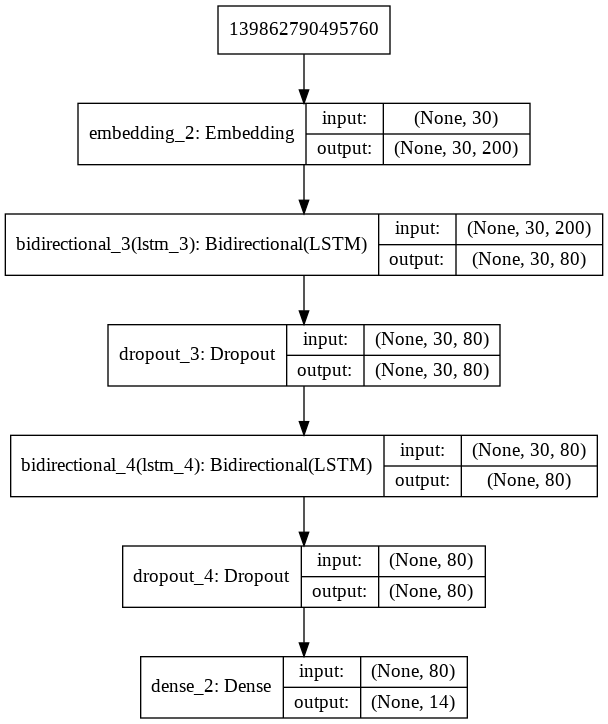

In [0]:

from IPython.display import Image
Image('/content/model.png')

In [0]:
history = model.fit(cluster_1_padded_sents, cluster_1_train_label, validation_split=0.3, epochs=20, batch_size=32, 
          verbose=1, callbacks=[reduce_rate,early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 76926 samples, validate on 32969 samples
Epoch 1/20
76926/76926 [==============================] - 217s 3ms/step - loss: 2.1974 - acc: 0.4453 - val_loss: 1.7898 - val_acc: 0.5028
Epoch 2/20
76926/76926 [==============================] - 213s 3ms/step - loss: 1.7124 - acc: 0.5316 - val_loss: 1.7955 - val_acc: 0.5069

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/20
76926/76926 [==============================] - 212s 3ms/step - loss: 1.4814 - acc: 0.5920 - val_loss: 1.6199 - val_acc: 0.5419
Epoch 4/20
76926/76926 [==============================] - 215s 3ms/step - loss: 1.4160 - acc: 0.6038 - val_loss: 1.5927 - val_acc: 0.5447
Epoch 5/20
76926/76926 [==============================] - 215s 3ms/step - loss: 1.3892 - acc: 0.6076 - val_loss: 1.5885 - val_acc: 0.5429
Epoch 6/20
76926/76926 [==============================] - 215s 3ms/step - loss: 1.3678 - acc: 0.6134 - val_loss: 1.5726 - val_acc:

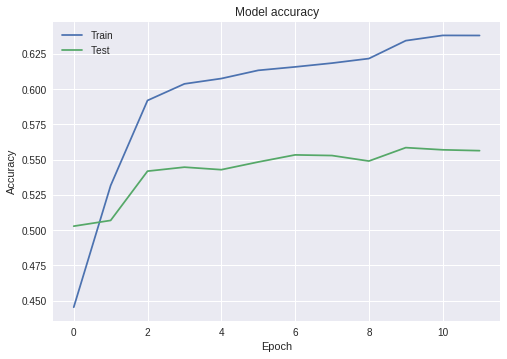

In [0]:
# Visualizing model
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

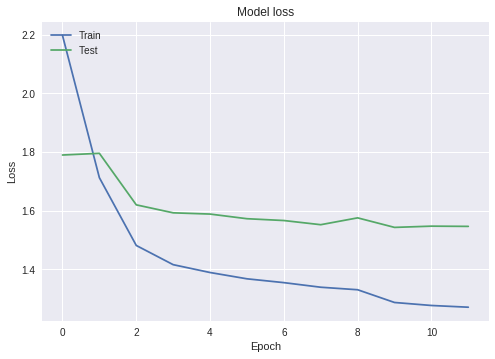

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# Saving the model
model.save('/content/gdrive/My Drive/Thesis Models/EN-DE-LEGDIV-2-Clusters_cluster_1.h5')

## Evaluation on Document level
SVMs are trained on document level and to make a fair evaluation the LSTMs needs to be evaluated on document level as well, but LSTM are trained on sentence level as due to hardware limitations one can not feed the whole document hence the technique used here is a little unique.

So to make a fair comparision, the evaluation has to be done manually, first the document has to be divided into sentences with same technique used during training, then when all the sentence from a single document is curated then they are encoded into numeric form and padded to make all of them of equal length.

Then each sentence is predicted and the predictions are normalized and combined to make it a single prediction for the whole document.

In [0]:
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

original_label = []   # list to store the original label 
predicted_label = []   # list to store the predicted label

for first_data, first_label in zip(cluster_1_data_test,cluster_1_label_test):
    ## TMP LIST for each doc
    sent_pred = []
    
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_1.items():
        if value == first_label:
            num = key
    
    doc_sent = []
    for slide in slides:
        
        a = ' '.join(slide)
        
        doc_sent.append(a)
    
        
    # we have the slide here, create the sequence from text to numbers
    text_sequence = tokenizer.texts_to_sequences(doc_sent)

    # pad it to make flat 30 lenght
    text_padded = keras.preprocessing.sequence.pad_sequences(text_sequence, maxlen=30, padding='post')


    # predict the label
    sent_pred.append(model.predict(text_padded))        
    
    # normailizing the predictions before combining them.
    nor_data = []
    for predc in sent_pred:
        transformer2 = Normalizer().fit(predc)
        nor_data.append(transformer2.transform(predc))    
        
    # adding all the predictions of sentences of a single document into one.
    sent = np.zeros(cluster_1_train_label.shape[1])
    for sen in nor_data:
        for i in range(len(sen)):
            sent += sen[i]
    
    # populating lists of the predicted labels and original labels for further evaluation
    predicted_label.append(np.argmax(sent, axis=0))
    original_label.append(num)

In [0]:
# Accuracy on document level
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy of the model on document level is: {:.2f} %".format(accuracy_score(original_label, predicted_label)*100))

Accuracy of the model on document level is: 75.84 %


In [0]:

# Classification report and confusion Matrix
np.set_printoptions(threshold=np.nan)
print(confusion_matrix(original_label, predicted_label))

[[ 43   0   0   1   2   0   0   2   2   0   0   0   0   0]
 [  0   1   1   0   0   0   0   0   0   8   0   0   0   0]
 [  0   0  25   0   0   0   0   0   0   0   1   0   0   4]
 [  2   0   0  48   1   0   0   2   2   2  11   0   0   6]
 [  0   0   0   0  83   0   1   0   0   3   7   0   0   0]
 [  0   0   0   1   0  36   0  14   0   1   2   2   0   0]
 [  3   0   0   0   3   0  11   2   0   3   4   0   0   0]
 [  0   0   0   6   2   0   0  74   0   0   2   0   0   4]
 [  0   0   0   6   0   0   0   4  62   0   4   0   0   0]
 [  0   0   0   0   2   0   0   0   0  67   7   0   0   4]
 [  0   0   0  12   7   1   4   1   0   4 111   1   1   6]
 [  0   0   0   7  15   0   0   0   1   0   2  19   0   0]
 [  0   0   0   0   2   0   0   1   0   2   1   0  20   2]
 [  0   0   0   0   0   0   1   6   0   4   2   0   0  81]]


In [0]:
print(classification_report(original_label, predicted_label))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        50
           1       1.00      0.10      0.18        10
           2       0.96      0.83      0.89        30
           3       0.59      0.65      0.62        74
           4       0.71      0.88      0.79        94
           5       0.97      0.64      0.77        56
           6       0.65      0.42      0.51        26
           7       0.70      0.84      0.76        88
           8       0.93      0.82      0.87        76
           9       0.71      0.84      0.77        80
          10       0.72      0.75      0.74       148
          11       0.86      0.43      0.58        44
          12       0.95      0.71      0.82        28
          13       0.76      0.86      0.81        94

   micro avg       0.76      0.76      0.76       898
   macro avg       0.81      0.69      0.71       898
weighted avg       0.78      0.76      0.75       898



## Evaluation on Sentence level


In [0]:
# Cluster 1 test data, sentence conversion
cluster_1_sent_test = []  # List to store the sentence
cluster_1_labels_test = [] # List to store the label(alpha)
cluster_1_label_num_test = []


for first_data, first_label in zip(cluster_1_data_test, cluster_1_label_test):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_1.items():
        if value == first_label:
            num = key
    
    
    for slide in slides:
        cluster_1_sent_test.append(' '.join(slide))
        cluster_1_labels_test.append(first_label)
        cluster_1_label_num_test.append(num)

cluster_1_test_label = onehot_encoder.fit_transform(np.reshape(cluster_1_label_num_test,(-1,1)))
cluster_1_test_sequences = tokenizer.texts_to_sequences(cluster_1_sent_test)


# Testing the data
cluster_1_padded_sents_test = keras.preprocessing.sequence.pad_sequences(cluster_1_test_sequences, maxlen=max_len, padding='post')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
len(cluster_1_padded_sents_test)

48781

In [0]:
scores = model.evaluate(cluster_1_padded_sents_test, cluster_1_test_label, verbose=1)
print("Accuracy on sentence level: %.2f%%" % (scores[1]*100))

48781/48781 [==============================] - 32s 662us/step
Accuracy on sentence level: 53.35%


In [0]:
pred = model.predict(cluster_1_padded_sents_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(cluster_1_test_label, axis=1)

In [0]:
print(confusion_matrix(y_true, y_pred))

[[2864    5  104  283  236   13   35  259  208  108  176   18   40   72]
 [  19  165   46   29   14    2    8   10    3  335   80    4    0    4]
 [  91    4  800   19   39   88   52   20    5   59  193    2   29  250]
 [ 127    3   20 1346  104   10    1  117  293  165  595   43   14  501]
 [ 103    8   14   82 3516   31  163  158   32  335  405  122   15   80]
 [  68    0   57  127  116 1167   60  506   34  184  210   37   18  118]
 [  73    0   32   49  172   87  360   95   12  184  177    6   23   60]
 [ 104    0    9  241  208  205   41 2518  123  149  243   55   16  237]
 [ 220    0    4  387   80    7    0  236 2264   34  266   82    6   71]
 [  64   26   16  208  435   53  100  143   15 2917  673   47   10  345]
 [ 144    1  125  716  749  137  189  229  198  880 3706  108   88  442]
 [  36   14    0  296  781   13   21  113  109  160  144  783    7   15]
 [  45    0   19   35  151   18    5   53   21   63  150    4  525   97]
 [  84    0   31  104  273  116   76  456   64  386

In [0]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68      4421
           1       0.73      0.23      0.35       719
           2       0.63      0.48      0.55      1651
           3       0.34      0.40      0.37      3339
           4       0.51      0.69      0.59      5064
           5       0.60      0.43      0.50      2702
           6       0.32      0.27      0.29      1330
           7       0.51      0.61      0.56      4149
           8       0.67      0.62      0.64      3657
           9       0.49      0.58      0.53      5052
          10       0.49      0.48      0.48      7712
          11       0.60      0.31      0.41      2492
          12       0.62      0.44      0.52      1186
          13       0.57      0.58      0.58      5307

   micro avg       0.53      0.53      0.53     48781
   macro avg       0.56      0.48      0.50     48781
weighted avg       0.54      0.53      0.53     48781



# Cluster 2

In [0]:
num_label_cluster_2 = dict(list(enumerate(sorted(set(cluster_2_label)))))
num_label_cluster_2

{0: 'budget',
 1: 'culture',
 2: 'customs',
 3: 'development',
 4: 'economic_and_monetary_affairs',
 5: 'education_training_youth',
 6: 'enlargement',
 7: 'external_relations',
 8: 'external_trade',
 9: 'fight_against_fraud',
 10: 'foreign_and_security_policy',
 11: 'human_rights',
 12: 'humanitarian_aid',
 13: 'institutional_affairs',
 14: 'justice_freedom_security',
 15: 'maritime_affairs_and_fisheries',
 16: 'regional_policy',
 17: 'research_innovation'}

In [0]:
# Document frequency
from collections import Counter
Counter(cluster_2_label)

Counter({'budget': 30,
         'culture': 28,
         'customs': 48,
         'development': 90,
         'economic_and_monetary_affairs': 212,
         'education_training_youth': 152,
         'enlargement': 96,
         'external_relations': 74,
         'external_trade': 84,
         'fight_against_fraud': 46,
         'foreign_and_security_policy': 74,
         'human_rights': 46,
         'humanitarian_aid': 46,
         'institutional_affairs': 196,
         'justice_freedom_security': 318,
         'maritime_affairs_and_fisheries': 126,
         'regional_policy': 74,
         'research_innovation': 82})

### Tain sentence preparation

In [0]:
# Cluster 2 train data, sentence conversion
cluster_2_sent_train = []  # List to store the sentence
cluster_2_labels_train = [] # List to store the label(alpha)
cluster_2_label_num_train = []


for second_data, second_label in zip(cluster_2_data, cluster_2_label):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(second_data.split(' '),30,10)
        
    for key,value in num_label_cluster_2.items():
        if value == second_label:
            num = key
    
    
    for slide in slides:
        cluster_2_sent_train.append(' '.join(slide))
        cluster_2_labels_train.append(second_label)
        cluster_2_label_num_train.append(num)
        
# Cluster 2 test data        
cluster_2_sent_test = []  # List to store the sentence
cluster_2_labels_test = [] # List to store the label(alpha)
cluster_2_label_num_test = []


for second_data, second_label in zip(cluster_2_data_test, cluster_2_label_test):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(second_data.split(' '),30,10)
        
    for key,value in num_label_cluster_2.items():
        if value == second_label:
            num = key
    
    
    for slide in slides:
        cluster_2_sent_test.append(' '.join(slide))
        cluster_2_labels_test.append(second_label)
        cluster_2_label_num_test.append(num)

In [0]:
Counter(cluster_2_labels_train)

Counter({'budget': 1801,
         'culture': 1753,
         'customs': 3034,
         'development': 5517,
         'economic_and_monetary_affairs': 15552,
         'education_training_youth': 9065,
         'enlargement': 6586,
         'external_relations': 5424,
         'external_trade': 5199,
         'fight_against_fraud': 2264,
         'foreign_and_security_policy': 3739,
         'human_rights': 2834,
         'humanitarian_aid': 2330,
         'institutional_affairs': 10380,
         'justice_freedom_security': 18374,
         'maritime_affairs_and_fisheries': 8561,
         'regional_policy': 4369,
         'research_innovation': 4867})

In [0]:
class_weight = dict()
ref_class = max(Counter(cluster_2_labels_train).values())

for key, value in Counter(cluster_2_labels_train).items():
    for _key, _value in num_label_cluster_2.items():
        if _value == key:
            class_weight[_key] = ref_class/value

In [0]:
class_weight

{0: 10.20210993892282,
 1: 10.481460353679406,
 2: 6.056031641397495,
 3: 3.330433206452782,
 4: 1.1814557613168724,
 5: 2.026916712630998,
 6: 2.7898572730033404,
 7: 3.387536873156342,
 8: 3.5341411809963454,
 9: 8.115724381625443,
 10: 4.914148167959348,
 11: 6.483415666901905,
 12: 7.885836909871244,
 13: 1.7701348747591523,
 14: 1.0,
 15: 2.146244597593739,
 16: 4.205539024948501,
 17: 3.775220875282515}

### Tokenizing train sentences & one hot encoding train test labels

In [0]:
# tokenizing cluster 2 sents
tokenizer_cls2 = Tokenizer()
tokenizer_cls2.fit_on_texts(cluster_2_sent_train)
cluster_2_train_sequences = tokenizer_cls2.texts_to_sequences(cluster_2_sent_train)
cluster_2_test_sequences = tokenizer_cls2.texts_to_sequences(cluster_2_sent_test)

# padding the sentences
cluster_2_padded_sents = keras.preprocessing.sequence.pad_sequences(cluster_2_train_sequences, maxlen=30, padding='post')

# checking vocab size
word_index_cls2 = tokenizer_cls2.word_index
vocab_size_cls2 = len(word_index_cls2)+1
onehot_encoder = OneHotEncoder(sparse=False)

onehot_encoder.fit(np.reshape(cluster_2_label_num_train,(-1,1)))

cluster_2_train_label = onehot_encoder.transform(np.reshape(cluster_2_label_num_train,(-1,1)))
cluster_2_test_label = onehot_encoder.transform(np.reshape(cluster_2_label_num_test,(-1,1)))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
print("Vocab Size: {}".format(vocab_size_cls2))

Vocab Size: 39316


### Embedding Matrix creation

In [0]:
# converting embedding matrix into a form that can be used in keras embedding layer
embeddings_index_cls2 = {}
with open(embding_path, 'r') as embpath:
    pretrained_embeding = embpath.readlines()
    
    for i, line in enumerate(pretrained_embeding):
        if i == 0:
            pass
        else:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index_cls2[word] = coefs
            
# preparing embedding matrix for cluster 2
embedding_matrix_cls2 = np.zeros((len(word_index_cls2) + 1, 200))
for word, i in word_index_cls2.items():
    embedding_vector = embeddings_index_cls2.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_cls2[i] = embedding_vector

In [0]:
learning_rate = 0.001
optimizer = keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)

In [0]:
# Other callbacks 
reduce_rate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=0, verbose=1, 
                                                mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=2, verbose=1, mode='auto')

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


## Model Creation

In [0]:
# Create sequential model_cls2
model_cls2 = Sequential()
model_cls2.add(emb(vocab_size_cls2, 200, weights=[embedding_matrix_cls2], input_length=30, trainable=False))   
model_cls2.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.1))))# LSTM layer 
model_cls2.add(keras.layers.Dropout(0.5))
model_cls2.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.1))))
model_cls2.add(keras.layers.Dropout(0.5))
model_cls2.add(Dense(18, activation='softmax'))
model_cls2.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
print(model_cls2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 200)           7863200   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 30, 80)            77120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 80)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 80)                38720     
_________________________________________________________________
dropout_6 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 18)                1458      
Total params: 7,980,498
Trainable params: 117,298
Non-trainable params: 7,863,200
____________________________________________________________

In [0]:
# Model visualization
from keras.utils import plot_model
plot_model(model_cls2, to_file='model_cls2.png', show_shapes=True, show_layer_names=True)

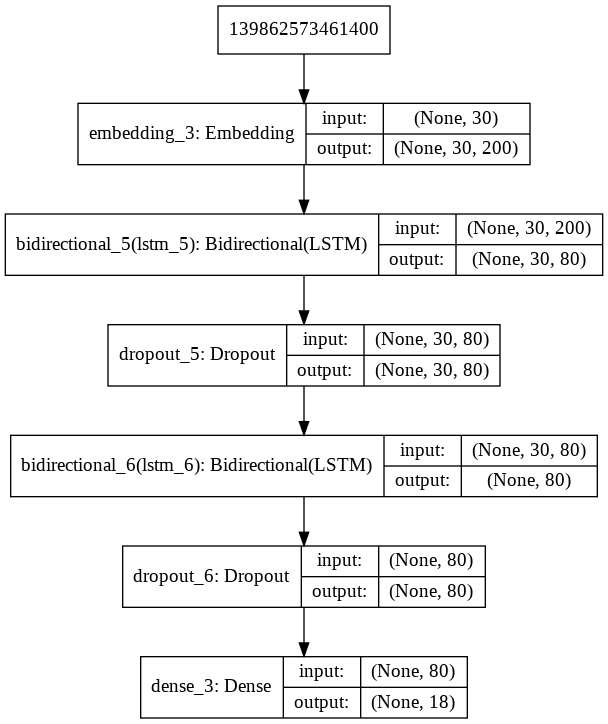

In [0]:
from IPython.display import Image
Image('/content/model_cls2.png')

In [0]:
model_cls2.fit(cluster_2_padded_sents, cluster_2_train_label, validation_split=0.3, epochs=20, batch_size=32, 
          verbose=1, callbacks=[reduce_rate,early_stop], class_weight=class_weight)

Train on 78154 samples, validate on 33495 samples
Epoch 1/20
78154/78154 [==============================] - 225s 3ms/step - loss: 7.8989 - acc: 0.3034 - val_loss: 7.0425 - val_acc: 0.3049
Epoch 2/20
78154/78154 [==============================] - 224s 3ms/step - loss: 6.2722 - acc: 0.4207 - val_loss: 6.6579 - val_acc: 0.3334
Epoch 3/20
78154/78154 [==============================] - 222s 3ms/step - loss: 5.9788 - acc: 0.4582 - val_loss: 6.5701 - val_acc: 0.3582
Epoch 4/20
78154/78154 [==============================] - 223s 3ms/step - loss: 5.8158 - acc: 0.4765 - val_loss: 6.4446 - val_acc: 0.3640
Epoch 5/20
78154/78154 [==============================] - 223s 3ms/step - loss: 5.7052 - acc: 0.4906 - val_loss: 6.8265 - val_acc: 0.3953

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/20
78154/78154 [==============================] - 220s 3ms/step - loss: 4.9603 - acc: 0.5434 - val_loss: 5.7560 - val_acc: 0.4379
Epoch 7/20
78154/78154 [================

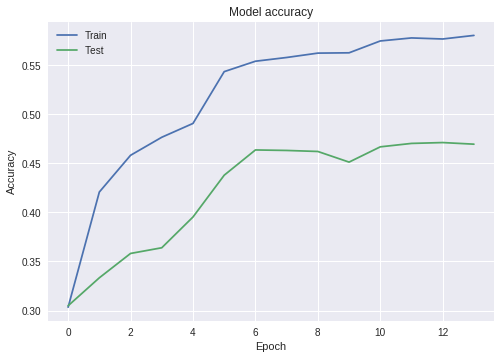

In [0]:
# Visualizing model
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(model_cls2.history.history['acc'])
plt.plot(model_cls2.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

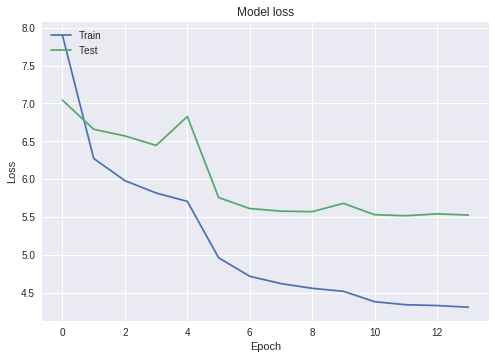

In [0]:
# Plot training & validation loss values
plt.plot(model_cls2.history.history['loss'])
plt.plot(model_cls2.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# Saving the model
model_cls2.save('/content/gdrive/My Drive/Thesis Models/EN-DE-LEGDIV-2-Clusters_cluster_2.h5')

## Evaluation on Document level
SVMs are trained on document level and to make a fair evaluation the LSTMs needs to be evaluated on document level as well, but LSTM are trained on sentence level as due to hardware limitations one can not feed the whole document hence the technique used here is a little unique.

So to make a fair comparision, the evaluation has to be done manually, first the document has to be divided into sentences with same technique used during training, then when all the sentence from a single document is curated then they are encoded into numeric form and padded to make all of them of equal length.

Then each sentence is predicted and the predictions are normalized and combined to make it a single prediction for the whole document.

In [0]:
cluster_2_train_label.shape[1]

18

In [0]:
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

original_label = []   # list to store the original label 
predicted_label = []   # list to store the predicted label

for first_data, first_label in zip(cluster_2_data_test,cluster_2_label_test):
    ## TMP LIST for each doc
    sent_pred = []
    
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_2.items():
        if value == first_label:
            num = key
    
    doc_sent = []
    for slide in slides:
        a = ' '.join(slide)
        doc_sent.append(a)
           
    # we have the slide here, create the sequence from text to numbers
    text_sequence = tokenizer_cls2.texts_to_sequences(doc_sent)

    # pad it to make flat 30 lenght
    text_padded = keras.preprocessing.sequence.pad_sequences(text_sequence, maxlen=30, padding='post')


    # predict the label
    sent_pred.append(model_cls2.predict(text_padded))        
    
    # normailizing the predictions before combining them.
    nor_data = []
    for predc in sent_pred:
        transformer2 = Normalizer().fit(predc)
        nor_data.append(transformer2.transform(predc))    
        
    # adding all the predictions of sentences of a single document into one.
    sent = np.zeros(cluster_2_train_label.shape[1])
    for sen in nor_data:
        for i in range(len(sen)):
            sent += sen[i]
    
    # populating lists of the predicted labels and original labels for further evaluation
    predicted_label.append(np.argmax(sent, axis=0))
    original_label.append(num)

In [0]:
# Accuracy on document level
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy of the model on document level is: {:.2f} %".format(accuracy_score(original_label, predicted_label)*100))

Accuracy of the model on document level is: 75.96 %


In [0]:
# Classification report and confusion Matrix
np.set_printoptions(threshold=np.nan)
print(confusion_matrix(original_label, predicted_label))

[[14  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  3  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 21  0  0  0  6  0  1  0  0  0  0  0  2  0  0  0]
 [ 0  0  0 30  0  0  0  0  3  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0 75  0  0  0  0  2  0  0  1  4  0  0  4  0]
 [ 0  0  0  0  0 49  0  0  0  0  2  1  0  0  0  0  0  0]
 [ 0  0  0  1  2  0 19  0  1  0  0  0  0  2  2  2  3  0]
 [ 0  0  0  8  1  0  0 24  4  0  0  0  0  0  6  0  1  0]
 [ 0  0  3  0  0  0  0  0 20  0  2  0  0  1  0  0  2  0]
 [ 0  1  6  0  0  0  0  0  0  8  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  0 20  0  0  0  0  0  1  2]
 [ 0  0  0  0  0  2  0  0  0  0  2 17  0  1  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  2  8  0  0  0  0  0]
 [ 0  0  1  0  0  3  0  0  0  0  0  1  0 39  7  0  0  9]
 [ 2  0  2  0  0  3  0  2  4  3  2  8  0 11 86  0  0  5]
 [ 2  0  0  2  1  0  0  0  0  0  0  0  0  0  0 49  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0 36  2]
 [ 0  0  0  0  0  0  0  0  0  0

In [0]:
print(classification_report(original_label, predicted_label))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       0.93      1.00      0.97        14
           2       0.64      0.70      0.67        30
           3       0.64      0.83      0.72        36
           4       0.95      0.87      0.91        86
           5       0.86      0.94      0.90        52
           6       0.76      0.59      0.67        32
           7       0.92      0.55      0.69        44
           8       0.61      0.71      0.66        28
           9       0.53      0.50      0.52        16
          10       0.62      0.83      0.71        24
          11       0.59      0.71      0.64        24
          12       0.67      0.57      0.62        14
          13       0.67      0.65      0.66        60
          14       0.81      0.67      0.74       128
          15       0.94      0.91      0.92        54
          16       0.72      0.86      0.78        42
          17       0.60    

## Evaluation on Sentence level


In [0]:
#loading the keras model 
from keras.models import load_model
model_cls2 = load_model('/content/gdrive/My Drive/Thesis Models/EN-DE-LEGDIV-2-Clusters_cluster_2.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
# Testing the data
cluster_2_padded_sents_test = keras.preprocessing.sequence.pad_sequences(cluster_2_test_sequences, maxlen=30, padding='post')

In [0]:
scores = model_cls2.evaluate(cluster_2_padded_sents_test, cluster_2_test_label, verbose=1)
print("Accuracy on sentence level: %.2f%%" % (scores[1]*100))

47157/47157 [==============================] - 177s 4ms/step
Accuracy on sentence level: 47.87%


In [0]:
pred = model_cls2.predict(cluster_2_padded_sents_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(cluster_2_test_label, axis=1)

In [0]:
print(confusion_matrix(y_true, y_pred))

[[ 482   10   35   79   62   22    4    3   24   70   22    8   14   40
     9   28  170   57]
 [   2  387    8   14    2   79   38    5    0    2   11   10    2   14
     5    5   33   35]
 [  11   91  881   18   12   14  305   42   80   69   27   17    2   43
   189  101   30   32]
 [  30   34   21  764   57   51   44  193  199   13   39   91  167   19
    10   25  156   73]
 [ 158  107   51   79 4689  104  476   26   43  239   78   23   27  203
    31   92  380  108]
 [   9  150   22   27   24 2121   27    7    8   13   87   78   10   42
   107   26  117  152]
 [  11   62   89  114  186   24  876   77   66   45   53   77   10  142
   156  236  160   78]
 [  23   95  117  429   51   59  105  680  341   45  111  132   28   48
   203   36  141  149]
 [  26   18  151  103   29    4   16   31  613   24   90   37   20  105
    35   64   51   34]
 [  13   36  166   12   23    6    2   32   48  266   16   15    2   29
    97   30   27   20]
 [  25   14   37   67    3   12   10   35   18   2

In [0]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.42      0.38      1139
           1       0.25      0.59      0.35       652
           2       0.37      0.45      0.40      1964
           3       0.27      0.38      0.32      1986
           4       0.85      0.68      0.76      6914
           5       0.66      0.70      0.68      3027
           6       0.35      0.36      0.35      2462
           7       0.45      0.24      0.32      2793
           8       0.34      0.42      0.38      1451
           9       0.17      0.32      0.22       840
          10       0.20      0.40      0.27      1061
          11       0.28      0.44      0.34      1417
          12       0.37      0.34      0.35      1050
          13       0.45      0.39      0.42      3687
          14       0.65      0.41      0.50      7592
          15       0.62      0.57      0.60      3276
          16       0.53      0.51      0.52      4443
          17       0.31    